<a href="https://colab.research.google.com/github/Mukul1Panwar/Deep-Learning/blob/main/Cnn(face_emotion).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [66]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.29GB/s]


In [ ]:
!unzip /content/fer2013.zip

In [68]:
pip install opencv-python

In [43]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Flatten,Dense,Dropout,GlobalAveragePooling1D,GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import os
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import load_model
from mtcnn import MTCNN

In [42]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.9 MB/s eta 0:00:00


In [69]:
train_dir = "/content/train"
test_dir = "/content/test"

In [70]:
print('train folder',os.listdir(train_dir))
print("test folder",os.listdir(test_dir))

train folder ['happy', 'neutral', 'sad', 'surprise', 'disgust', 'fear', 'angry']
test folder ['happy', 'neutral', 'sad', 'surprise', 'disgust', 'fear', 'angry']


In [71]:
angry_img = os.listdir("/content/train/angry")[0]

In [72]:
angry_img_path = os.path.join(train_dir, "angry", angry_img)
img = image.load_img(angry_img_path)

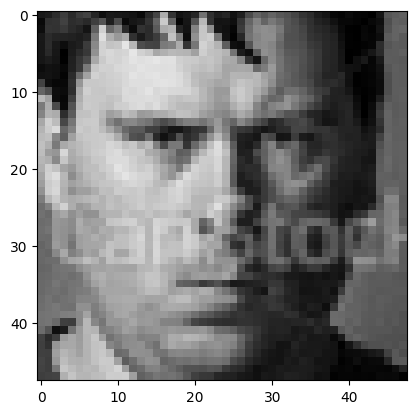

In [73]:
plt.imshow(img)

In [ ]:
# ImageDataGenerator for training

In [74]:
train_gen_aug = ImageDataGenerator(
    rescale= 1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],
    validation_split=0.2
)

In [ ]:
# you apply the generator on 80% of your train folder

In [75]:
train_generator = train_gen_aug.flow_from_directory(
    train_dir,
    target_size = (48,48),
    color_mode='grayscale',
    batch_size= 64,
    class_mode = 'categorical',
    subset = 'training'
)

Found 22968 images belonging to 7 classes.


image_size: (64, 48, 48, 1)


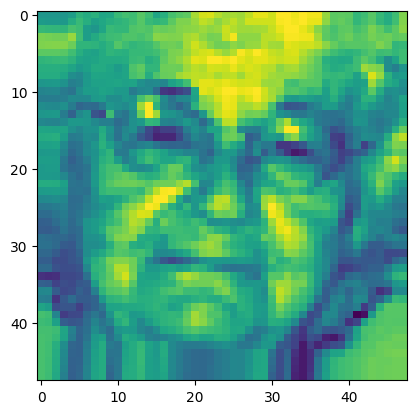

In [ ]:
images,labels = next(train_generator)

print("image_size:",images.shape)

plt.imshow(images[0])
plt.show()

In [ ]:
# here you apply the train_gen_aug on rest of your train folder(20%)

In [ ]:
valadition_gen = train_gen_aug.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    subset = 'validation'
)

Found 5741 images belonging to 7 classes.


In [ ]:
# ImageDataGenerator for test folder

In [ ]:
test_gen = ImageDataGenerator(
    rescale = 1./255
) # no need for data augumentation here

In [ ]:
# apply the test_gen on test_dir

In [ ]:
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(48,48),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=64,
    shuffle=False # shuffling between the folders
)

Found 7178 images belonging to 7 classes.


image_size: (64, 48, 48, 1)


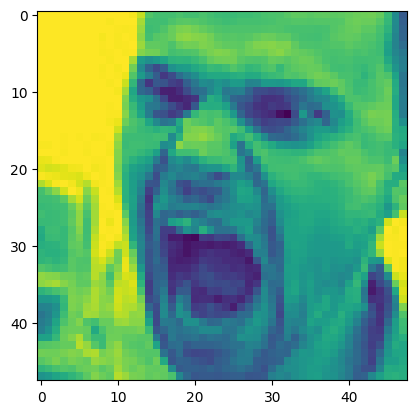

In [ ]:
images,labels = next(test_generator)

print("image_size:",images.shape)

plt.imshow(images[9])
plt.show()

In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
len(train_generator.classes)

22968

In [ ]:
test_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
print('Train directory')
for classs in os.listdir(train_dir):
  count = len(os.listdir((os.path.join(train_dir,classs))))
  print(f"{classs}",count)

Train directory
sad 4830
fear 4097
angry 3995
neutral 4965
surprise 3171
happy 7215
disgust 436


In [ ]:
print("Test directory")
for classs in os.listdir(test_dir):
  count = len(os.listdir(os.path.join(test_dir,classs)))
  print(f"{classs}",count)

Test directory
sad 1247
fear 1024
angry 958
neutral 1233
surprise 831
happy 1774
disgust 111


In [ ]:
class_weight0 = compute_class_weight(
    class_weight='balanced',
    classes = np.unique(train_generator.classes),
    y = train_generator.classes
)

# So if a class has fewer samples, it gets a higher weight (model focuses more on it).
# If a class has many samples (like happy), it gets a smaller weight.


In [ ]:
class_weight0 = dict(enumerate(class_weight0))
class_weight0

{0: np.float64(1.0266404434114071),
 1: np.float64(9.401555464592715),
 2: np.float64(1.0009587727708533),
 3: np.float64(0.5684585684585685),
 4: np.float64(0.826068191627104),
 5: np.float64(0.8491570541259982),
 6: np.float64(1.2933160650937552)}

In [ ]:
# This means the model will favor the majority class (like “happy”), because it doesn’t account for imbalance.

class_weight1 = compute_class_weight(
    class_weight=None,
    classes = np.unique(train_generator.classes),
    y = train_generator.classes
)
class_weight1

array([1., 1., 1., 1., 1., 1., 1.])

In [ ]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu',kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.25))


model.add(Dense(7,activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,686,791 (6.43 MB)

 Trainable params: 1,684,871 (6.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=5e-4),metrics=['accuracy'])

In [ ]:
# Reduce the lr when val_loss stops improving

R_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience=4, # weit 4 epochs with no improvement before reducing lr
    min_lr=1e-6,
    verbose = 1
)

# stop the training if val_loss not improve

e_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_model.keras",   # file to save
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


In [ ]:
callback = [R_lr, e_stop ,checkpoint]

In [ ]:
class_weight = {k: min(v, 4.0) for k, v in class_weight.items()}

In [ ]:
class_weight

{0: np.float64(1.0266404434114071),
 1: 4.0,
 2: np.float64(1.0009587727708533),
 3: np.float64(0.5684585684585685),
 4: np.float64(0.826068191627104),
 5: np.float64(0.8491570541259982),
 6: np.float64(1.2933160650937552)}

In [ ]:
history = model.fit(train_generator,validation_data=valadition_gen,epochs=100,callbacks=callback,class_weight=class_weight)  # total batches is 359 = 22000/64

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3821 - loss: 1.5270
Epoch 1: val_accuracy improved from 0.37014 to 0.40237, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.3821 - loss: 1.5270 - val_accuracy: 0.4024 - val_loss: 1.5776 - learning_rate: 5.0000e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4238 - loss: 1.4477
Epoch 2: val_accuracy did not improve from 0.40237
359/359 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.4238 - loss: 1.4477 - val_accuracy: 0.3588 - val_loss: 1.6490 - learning_rate: 5.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4384 - loss: 1.4120
Epoch 3: val_accuracy improved from 0.40237 to 0.42466, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.4385 - loss: 1.4120 - val_accuracy: 0.4247 - val_loss: 1.5259 - learning_rate: 5.0000e-04
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 

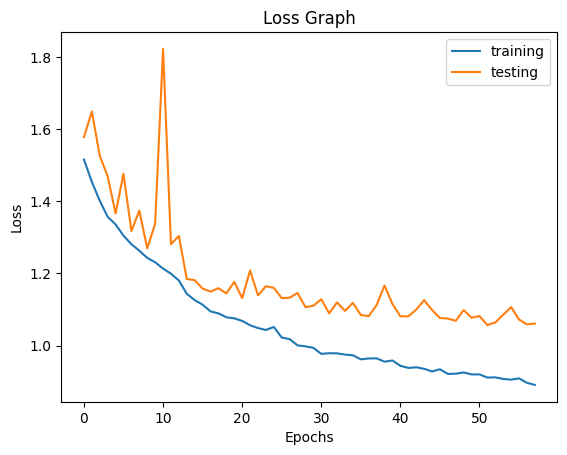

In [ ]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='testing')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.show()

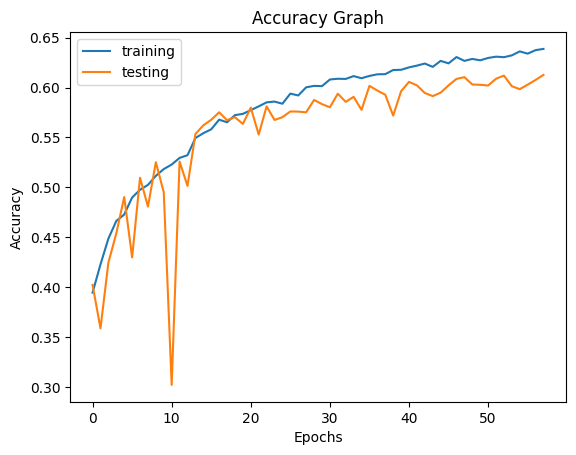

In [ ]:
plt.plot(history.history['accuracy'],label='training')
plt.plot(history.history['val_accuracy'],label='testing')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print("Loss",loss)
print("Accuracy",accuracy)

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5872 - loss: 1.1246
Loss 1.0175412893295288
Accuracy 0.6336026787757874


In [ ]:
loss, accuracy = model.evaluate(train_generator)


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.6775 - loss: 0.8681


In [ ]:
# testing

In [2]:
model = load_model("/content/best_model.keras")

The model is trained only face i said again only face, but when we perform testing we give the whole picture as a input . So it confuse to capture the face. The below code is not focusing on face it make focus to whole body, So it do not make right pridection.


Upload the Image: /content/students/anuj/471670458_1299982377719930_6923833961589381321_n.webp


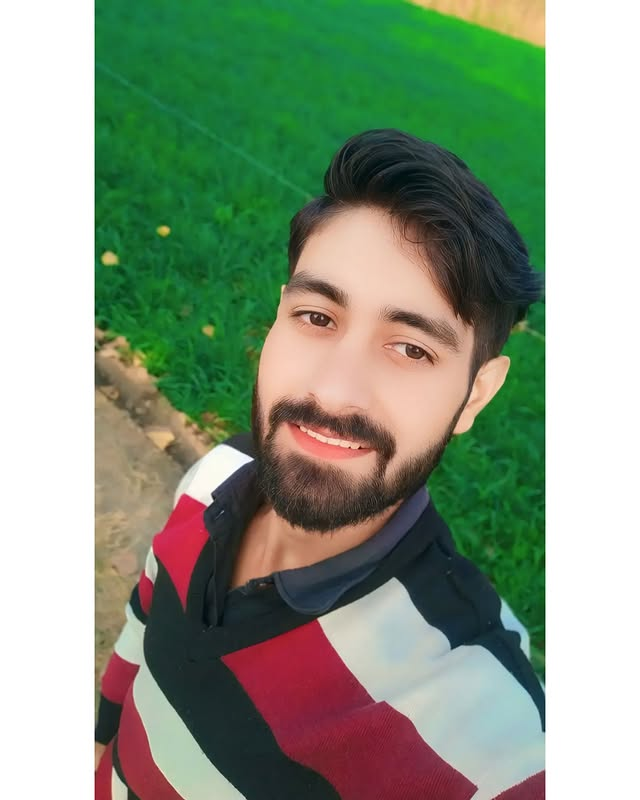

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Angry


In [57]:
input_image = input("Upload the Image: ")
input_image = cv2.imread(input_image)
cv2_imshow(input_image)


input_image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

input_image_resize = cv2.resize(input_image_gray, (48,48))
input_image_rescale = input_image_resize / 255.0

input_image_reshape = np.reshape(input_image_rescale, (1,48,48,1))

classes = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

prediction = model.predict(input_image_reshape)
prediction = np.argmax(prediction)
prediction = classes[prediction]


print(prediction)


This code is improvement of above code. It perform 61 % right prediction, because it majorly focus on face of input image.

Enter the Path of image: /content/Gemini_Generated_Image_zb59tzzb59tzzb59.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


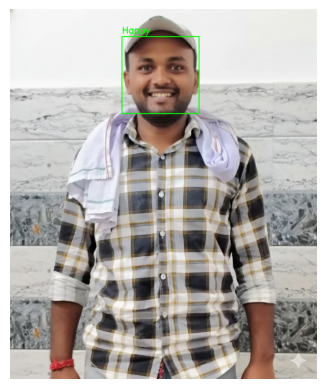

Happy


In [76]:
image_path = input("Enter the Path of image: ")
img = cv2.imread(image_path)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Define the face cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect all faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

# If multiple faces detected, keep the largest one
if len(faces) > 0:
    faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)  # sort by area
    (x, y, w, h) = faces[0]  # take the largest face

    face_img = gray[y:y+h, x:x+w]
    face_img = cv2.resize(face_img, (48,48))
    face_img = face_img / 255.0
    face_img = np.expand_dims(face_img, axis=[0,-1])

    pred = model.predict(face_img)
    prediction = np.argmax(pred)
    label = classes[prediction]

    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(label)
else:
    print("No face detected.")

Try to Capture the live face emotions.

In [ ]:
# Emotion labels
classes = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}

# Start webcam
cap = cv2.VideoCapture(0)  # use 0 or 1 if your default webcam is not detected

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize to model input size
    face_img = cv2.resize(gray, (48, 48))
    face_img = face_img / 255.0
    face_img = np.reshape(face_img, (1, 48, 48, 1))

    # Predict emotion
    pred = model.predict(face_img)
    emotion = classes[np.argmax(pred)]

    # Display emotion on the frame
    cv2.putText(frame, emotion, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Show the live frame
    cv2.imshow("Live Emotion Detection", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


Failed to grab frame
